## Setup

In [11]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [12]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'MoveToDrawerOpen'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [14]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [15]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([92, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([92]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([92, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([92, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([92, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([92, 3, 256, 256]), device=cpu, dtype=to

In [16]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=10,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [17]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-16 22:04:55.755 | INFO     |  Fitting AutoTPGMM
2025-06-16 22:04:55.756 | INFO     |  Segmenting trajectories


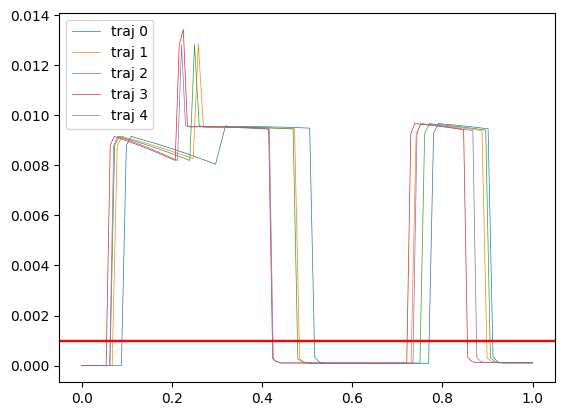

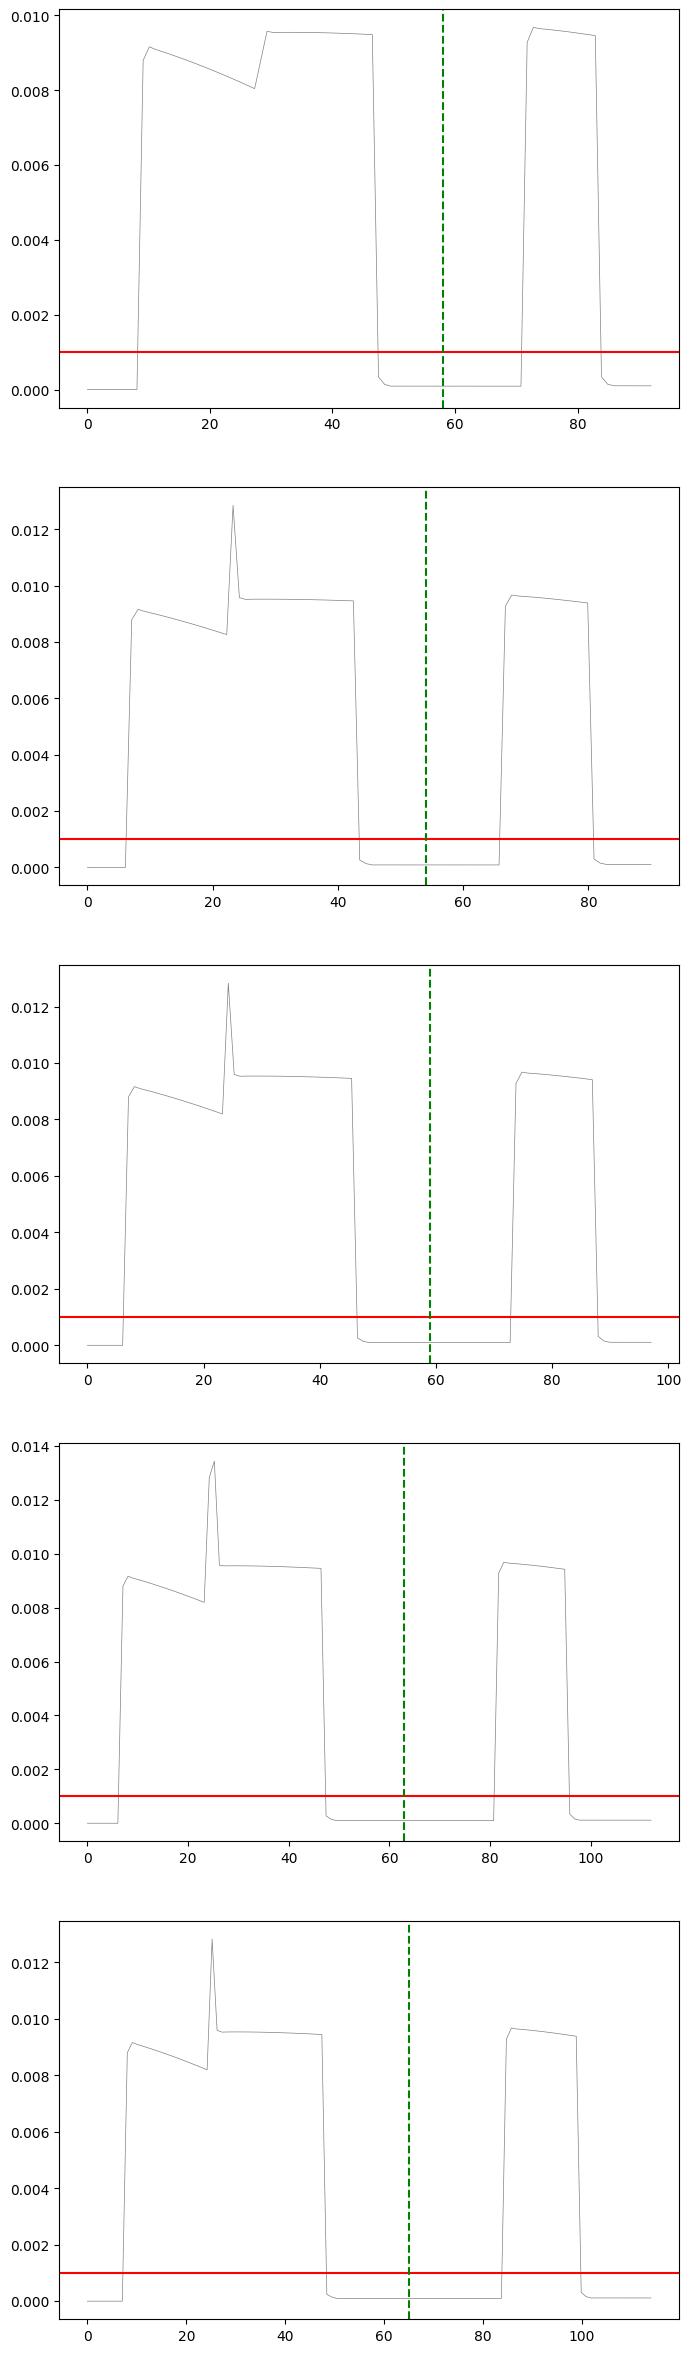

2025-06-16 22:04:56.569 | INFO     |  Creating segement of demos.
2025-06-16 22:04:56.578 | INFO     |  Subsampling to length 68 using strategy mean-length.
2025-06-16 22:04:56.579 | INFO     |  Creating segement of demos.
2025-06-16 22:04:56.587 | INFO     |  Subsampling to length 50 using strategy mean-length.
2025-06-16 22:04:56.588 | INFO     |  ... created 2 segments
2025-06-16 22:04:56.589 | INFO     |    Fitting candidate frame 1/10
2025-06-16 22:04:56.589 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:57.002 | INFO     |    Fitting candidate frame 2/10
2025-06-16 22:04:57.003 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:57.265 | INFO     |    Fitting candidate frame 3/10
2025-06-16 22:04:57.266 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:57.529 | INFO     |    Fitting candidate frame 4/10
2025-06-16 22:04:57.530 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:57.807 | INFO     |    Fitting candidate frame 5/10
2025-06-16 22:04:57.807 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:58.115 | INFO     |    Fitting candidate frame 6/10
2025-06-16 22:04:58.116 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:58.421 | INFO     |    Fitting candidate frame 7/10
2025-06-16 22:04:58.421 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:58.685 | INFO     |    Fitting candidate frame 8/10
2025-06-16 22:04:58.685 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:59.130 | INFO     |    Fitting candidate frame 9/10
2025-06-16 22:04:59.130 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:04:59.686 | INFO     |    Fitting candidate frame 10/10
2025-06-16 22:04:59.686 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 22:05:00.110 | INFO     |  Creating partial frame view of demos.
2025-06-16 22:05:00.113 | INFO     |    Fitting candidate frame 1/10
2025-06-16 22:05:00.114 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:00.371 | INFO     |    Fitting candidate frame 2/10
2025-06-16 22:05:00.372 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:00.555 | INFO     |    Fitting candidate frame 3/10
2025-06-16 22:05:00.556 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:00.843 | INFO     |    Fitting candidate frame 4/10
2025-06-16 22:05:00.843 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:01.174 | INFO     |    Fitting candidate frame 5/10
2025-06-16 22:05:01.174 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:01.415 | INFO     |    Fitting candidate frame 6/10
2025-06-16 22:05:01.416 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:01.669 | INFO     |    Fitting candidate frame 7/10
2025-06-16 22:05:01.670 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:01.920 | INFO     |    Fitting candidate frame 8/10
2025-06-16 22:05:01.920 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:02.289 | INFO     |    Fitting candidate frame 9/10
2025-06-16 22:05:02.289 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:02.768 | INFO     |    Fitting candidate frame 10/10
2025-06-16 22:05:02.769 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 22:05:03.122 | INFO     |  Creating partial frame view of demos.
2025-06-16 22:05:03.124 | INFO     |  Segmented trajs into 2 segments
2025-06-16 22:05:03.129 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142860 -0.142916 -0.142916 -0.142916 -0.142916 -0.142916   
Segment 1 -0.142869 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142916 -1.316945e-10 -1.218739e-10 -1.919267e-09  
Segment 1 -0.142857 -8.106076e-11 -8.645209e-11 -1.514861e-09  
2025-06-16 22:05:03.134 | INFO     |  Frame score (rel):
           ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  0.99961  1.000000  1.000000  1.000000  1.000000  1.000000   
Segment 1  1.00000  0.999914  0.999914  0.999914  0.999914  0.999914   

             obj005        obj006        obj007        obj008  
Segment 0  1.000000  9.214848e-10  8.527689e-10

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[6.59e+023, 6.59e+023, 2.80e+023, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [7.63e+019, 2.94e+020, 8.77e+020, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.65e-087, 1.28e-086, 5.72e-086, ..., 4.06e-010, 2.75e-010,
          1.75e-010],
         [2.79e-219, 4.73e-217, 7.26e-215, ..., 3.81e+019, 2.91e+019,
          2.02e+019]]),
  array([[7.88e+008, 1.10e+010, 5.92e+009, 1.44e+009, 1.57e+008, 7.67e+006,
          1.68e+005, 1.66e+003, 7.36e+000, 1.46e-002, 1.31e-005, 5.25e-009,
          9.46e-013, 7.65e-017, 2.78e-021, 4.53e-026, 1.36e-031, 2.84e-038,
          4.23e-044, 2.83e-052, 1.36e-061, 4.67e-072, 1.17e-083, 2.18e-096,
          3.02e-110, 1.69e-118, 8.00e-134, 2.91e-150, 8.06e-168, 1.80e-186,
          1.25e-196, 7.29e-207, 1.52e-217, 1.62e-228, 7.74e-240, 1.66e-251,
          1.60e-263, 6.91e-276, 1.34e-288, 1.03e-301, 3.54e-315, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0

In [18]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-16 22:05:04.069 | INFO     |  Did not specify time_based, deciding automatically.


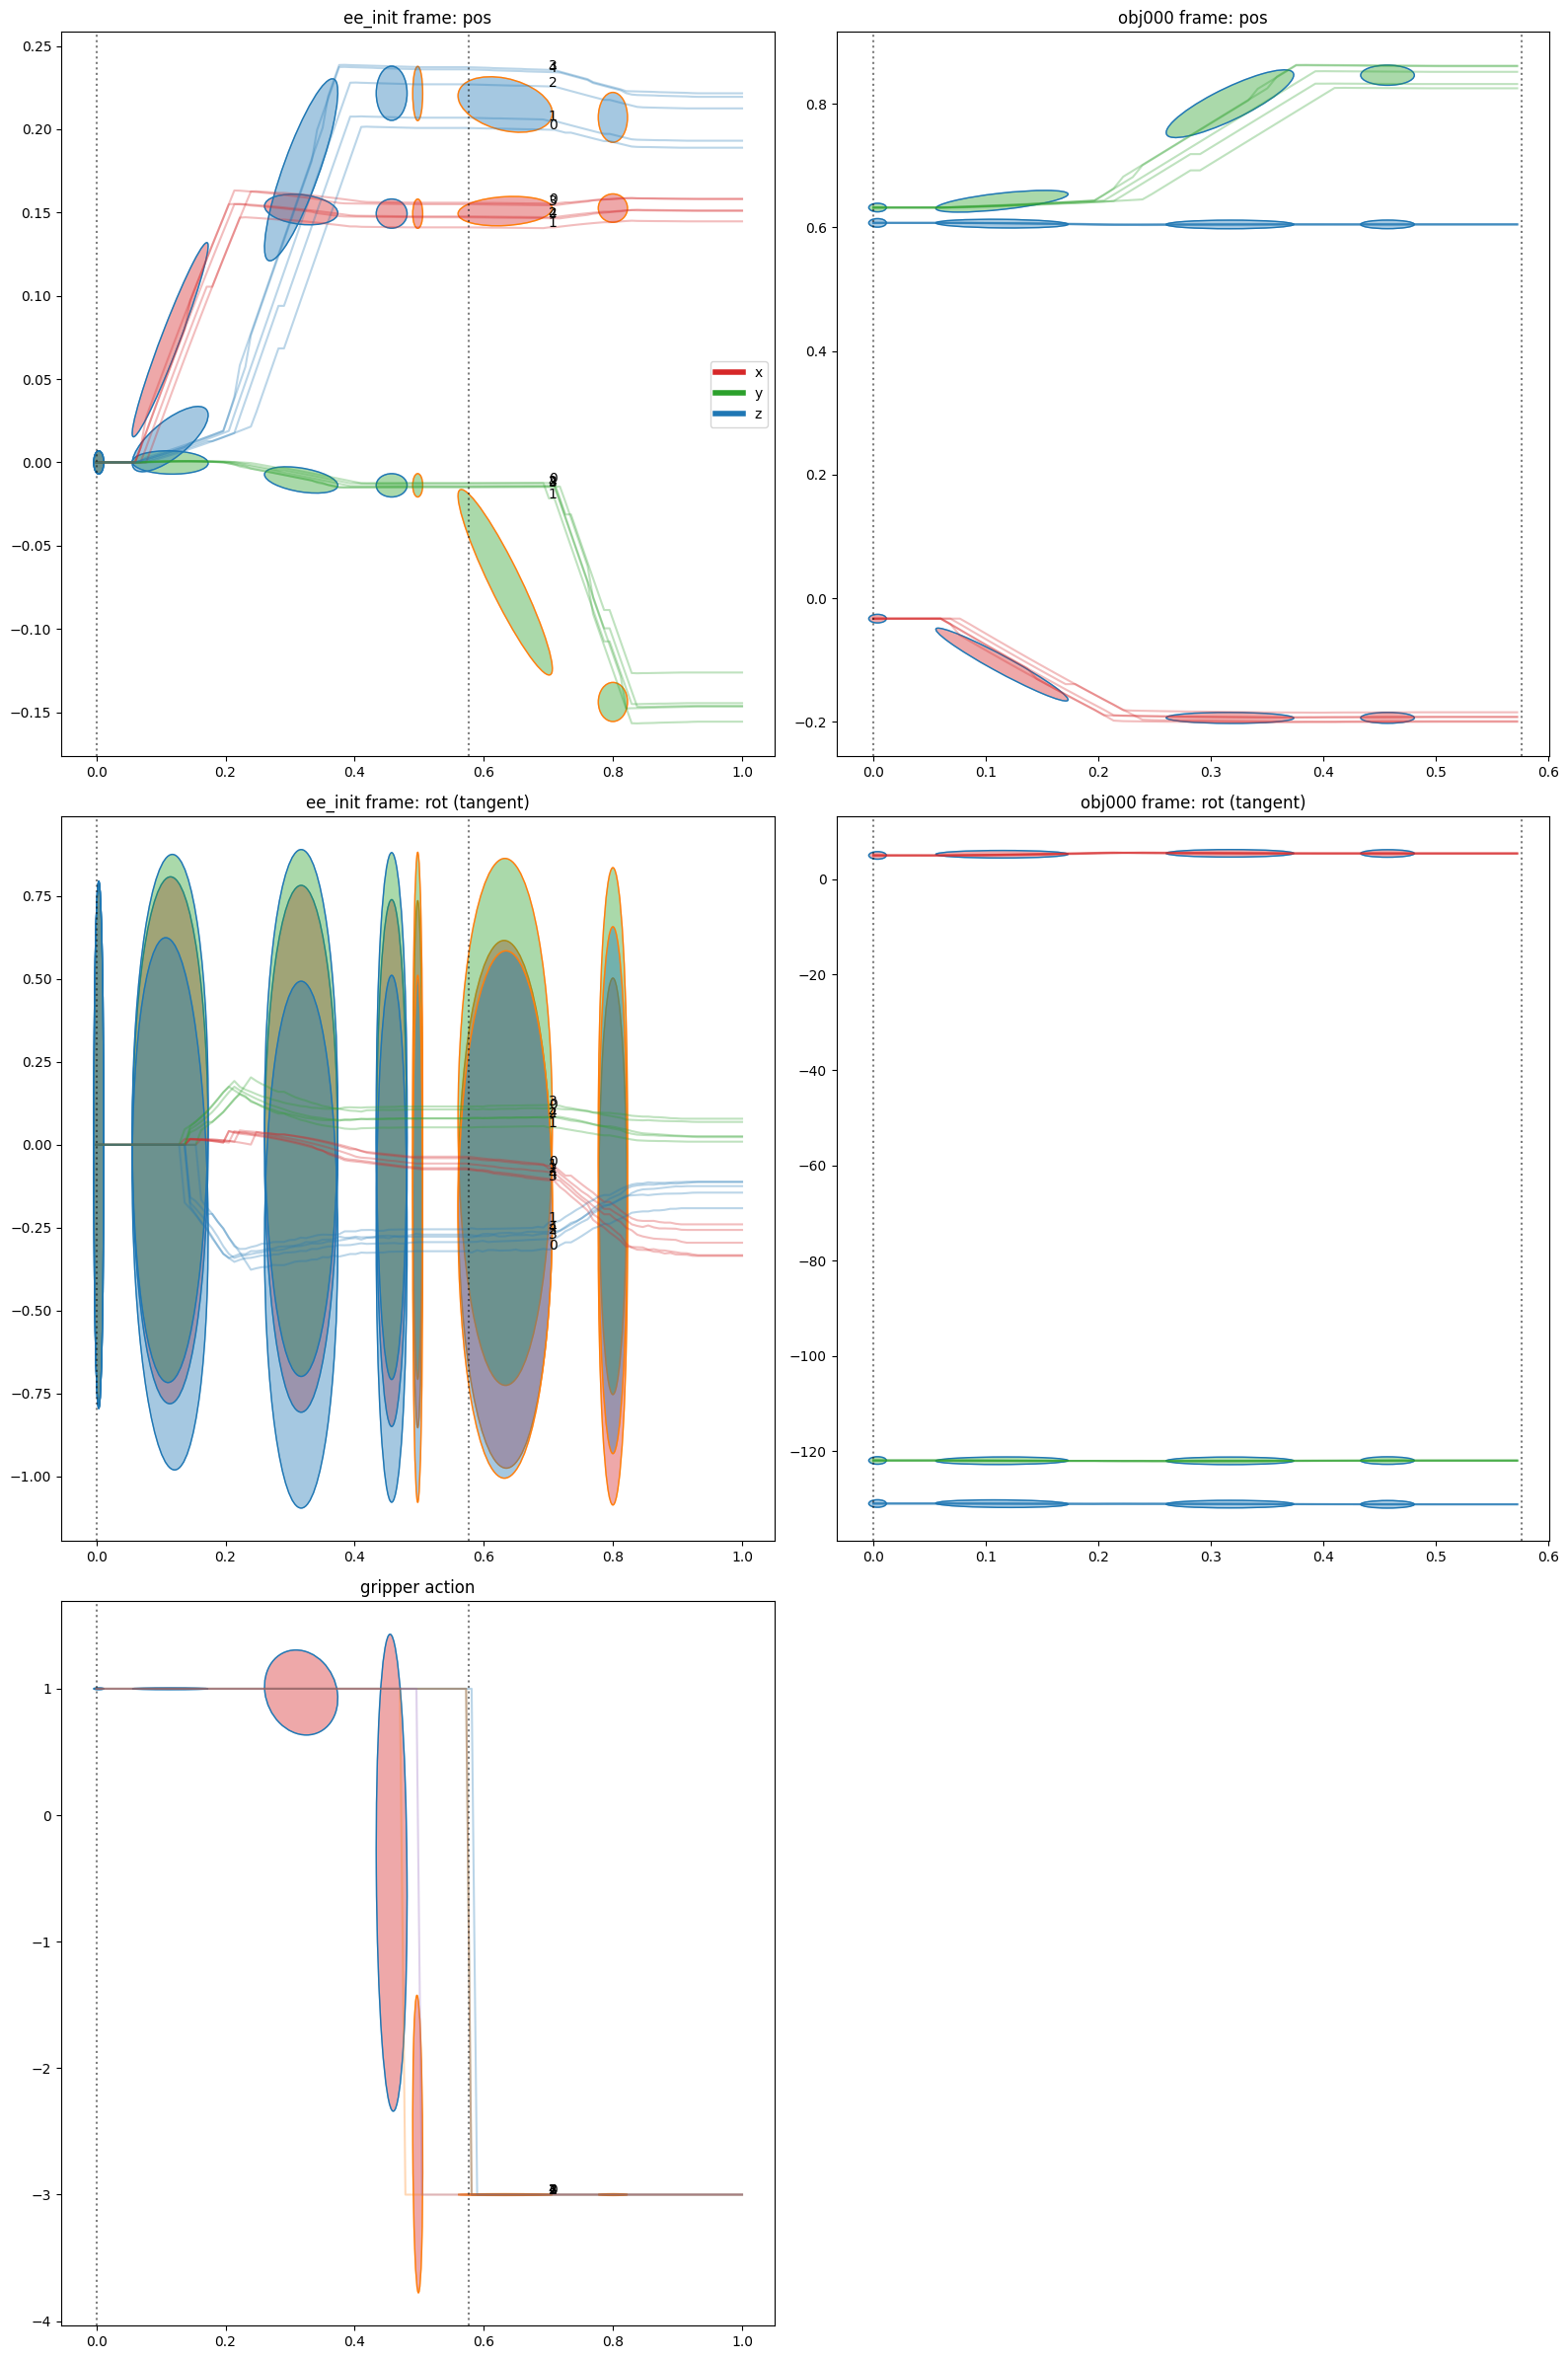

In [19]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [20]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-16 22:05:06.276 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-06-16 22:05:15.196 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 6.09e-31, 5.82e-23, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 9.89e-001, 6.66e-001, 3.89e-002,
          3.61e-005, 2.41e-010, 5.51e-018, 2.06e-028, 5.98e-042, 6.41e-059,
          1.21e-079, 1.93e-104, 1.23e-133, 1.49e-167, 4.51e-207, 2.45e-253,
          2.37e-305, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.93e-001,
          

2025-06-16 22:05:16.822 | INFO     |  Did not specify time_based, deciding automatically.


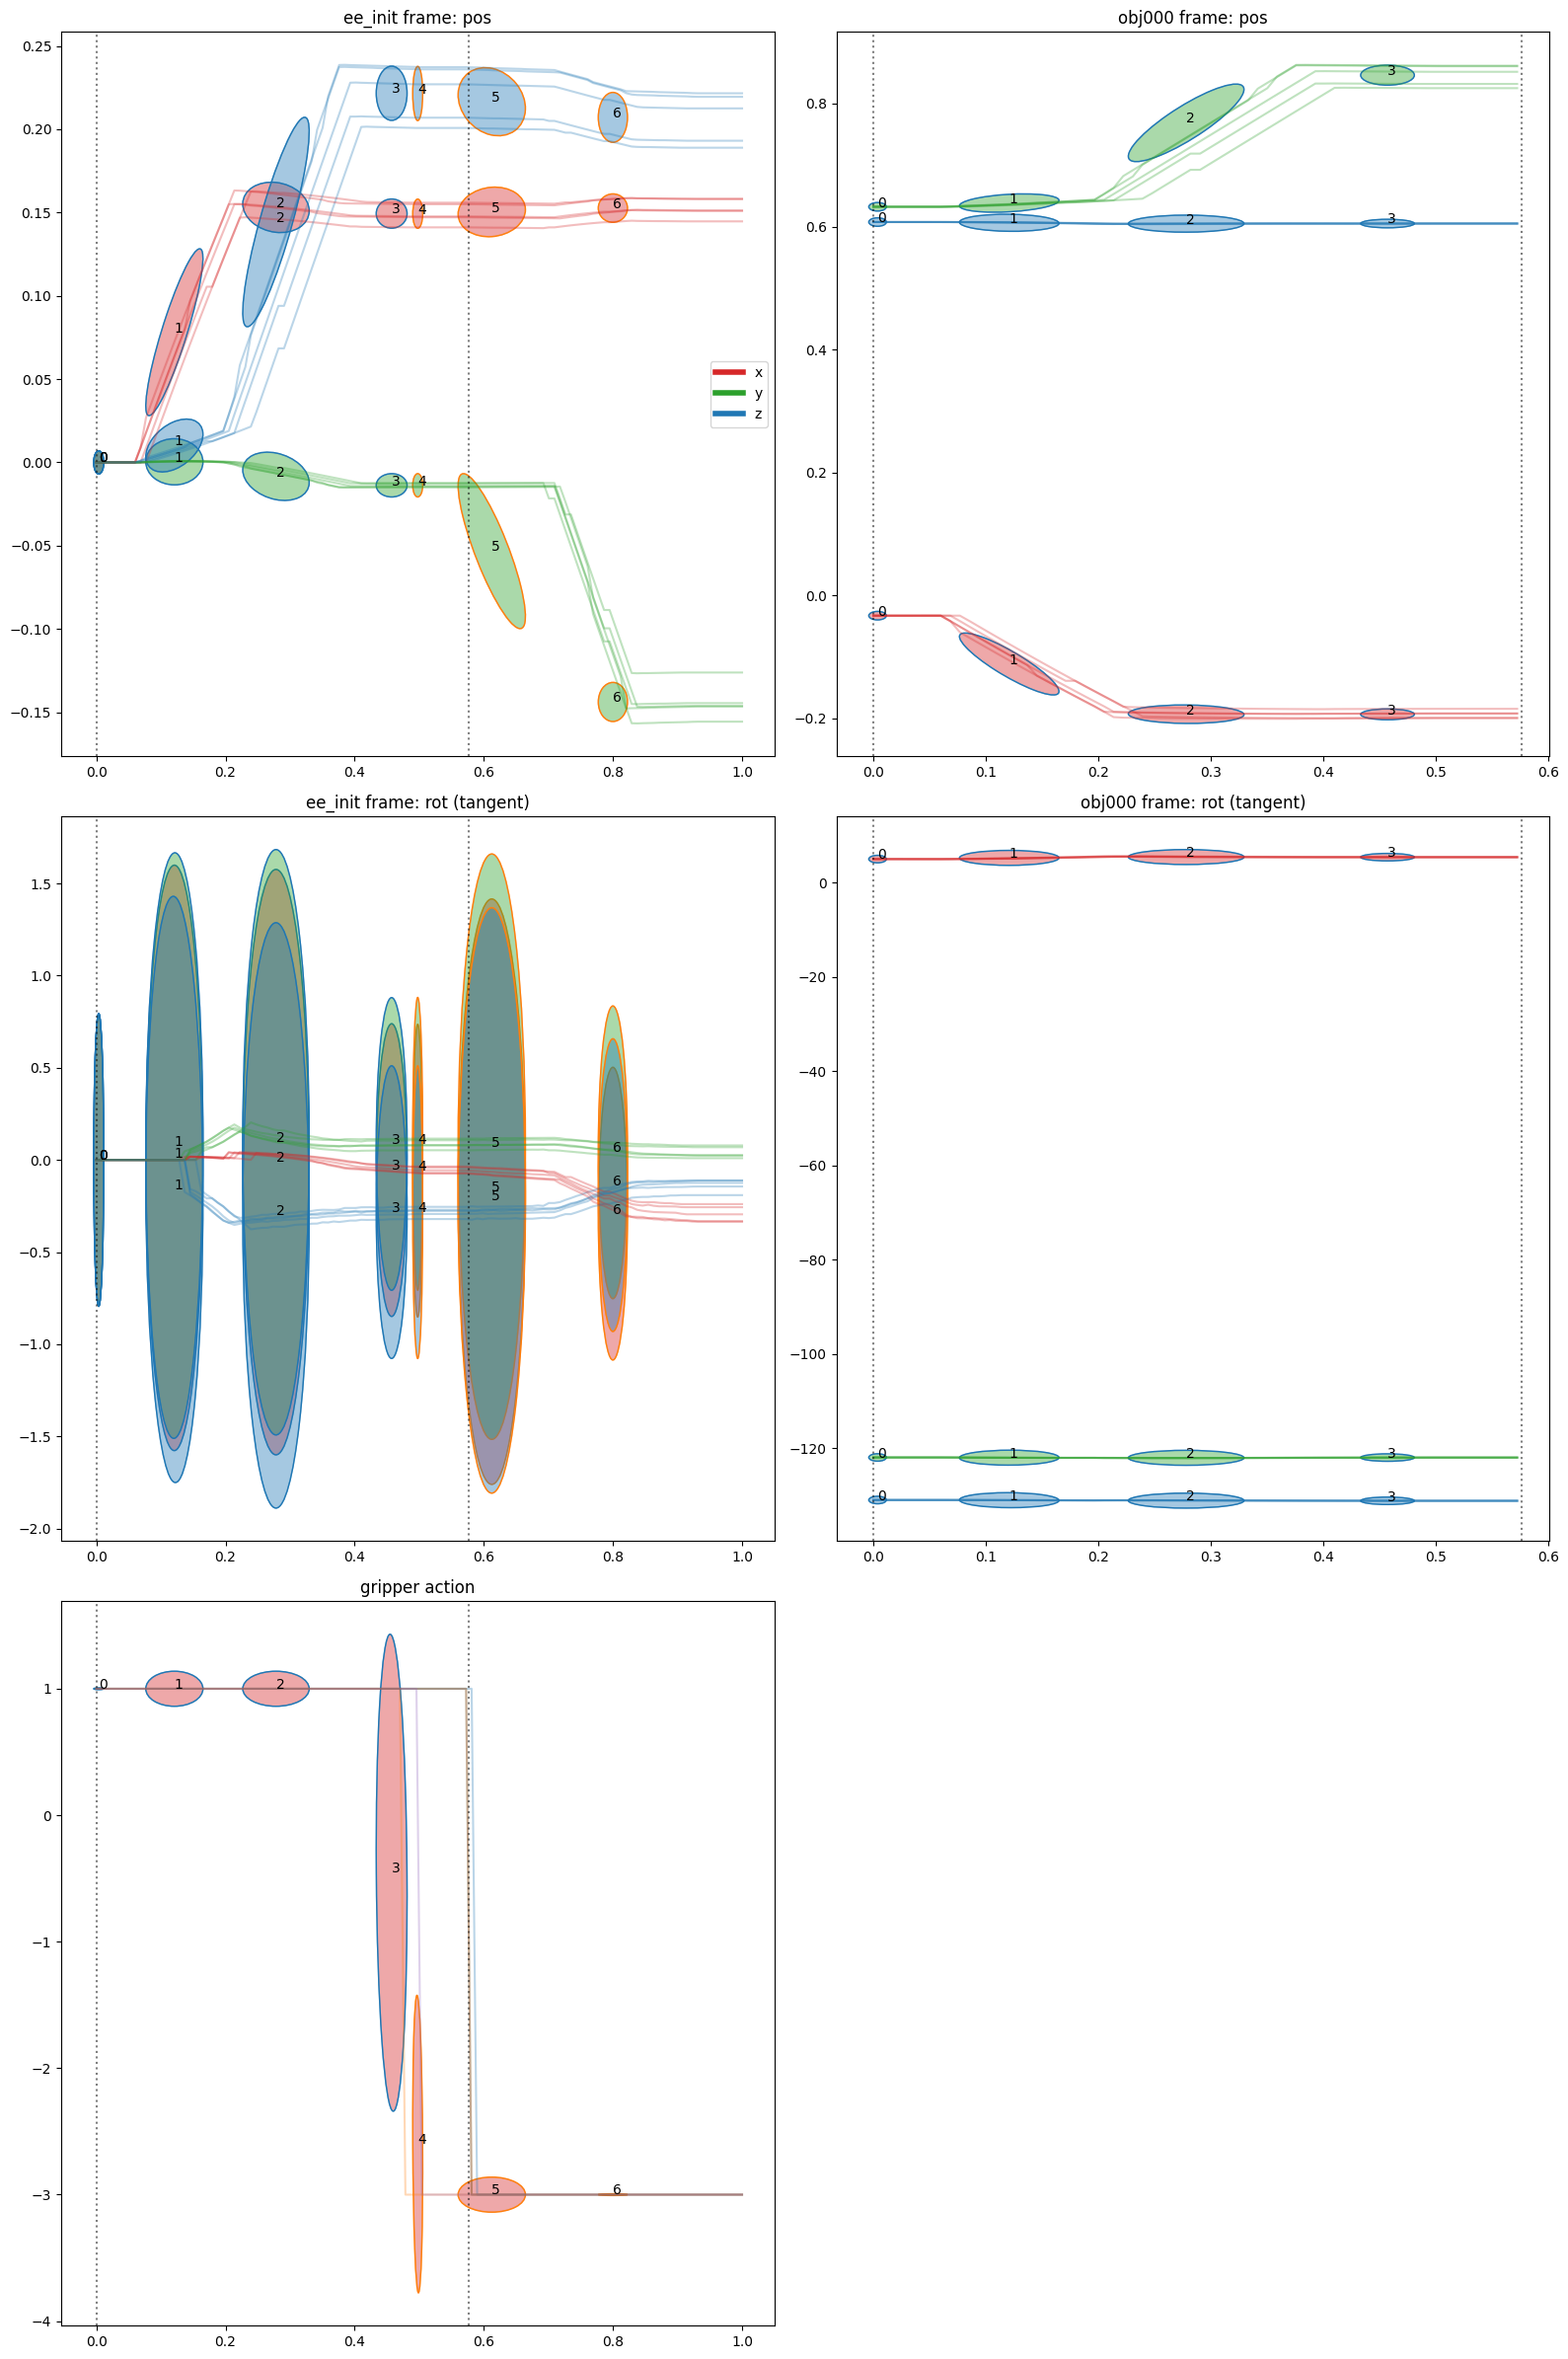

In [21]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

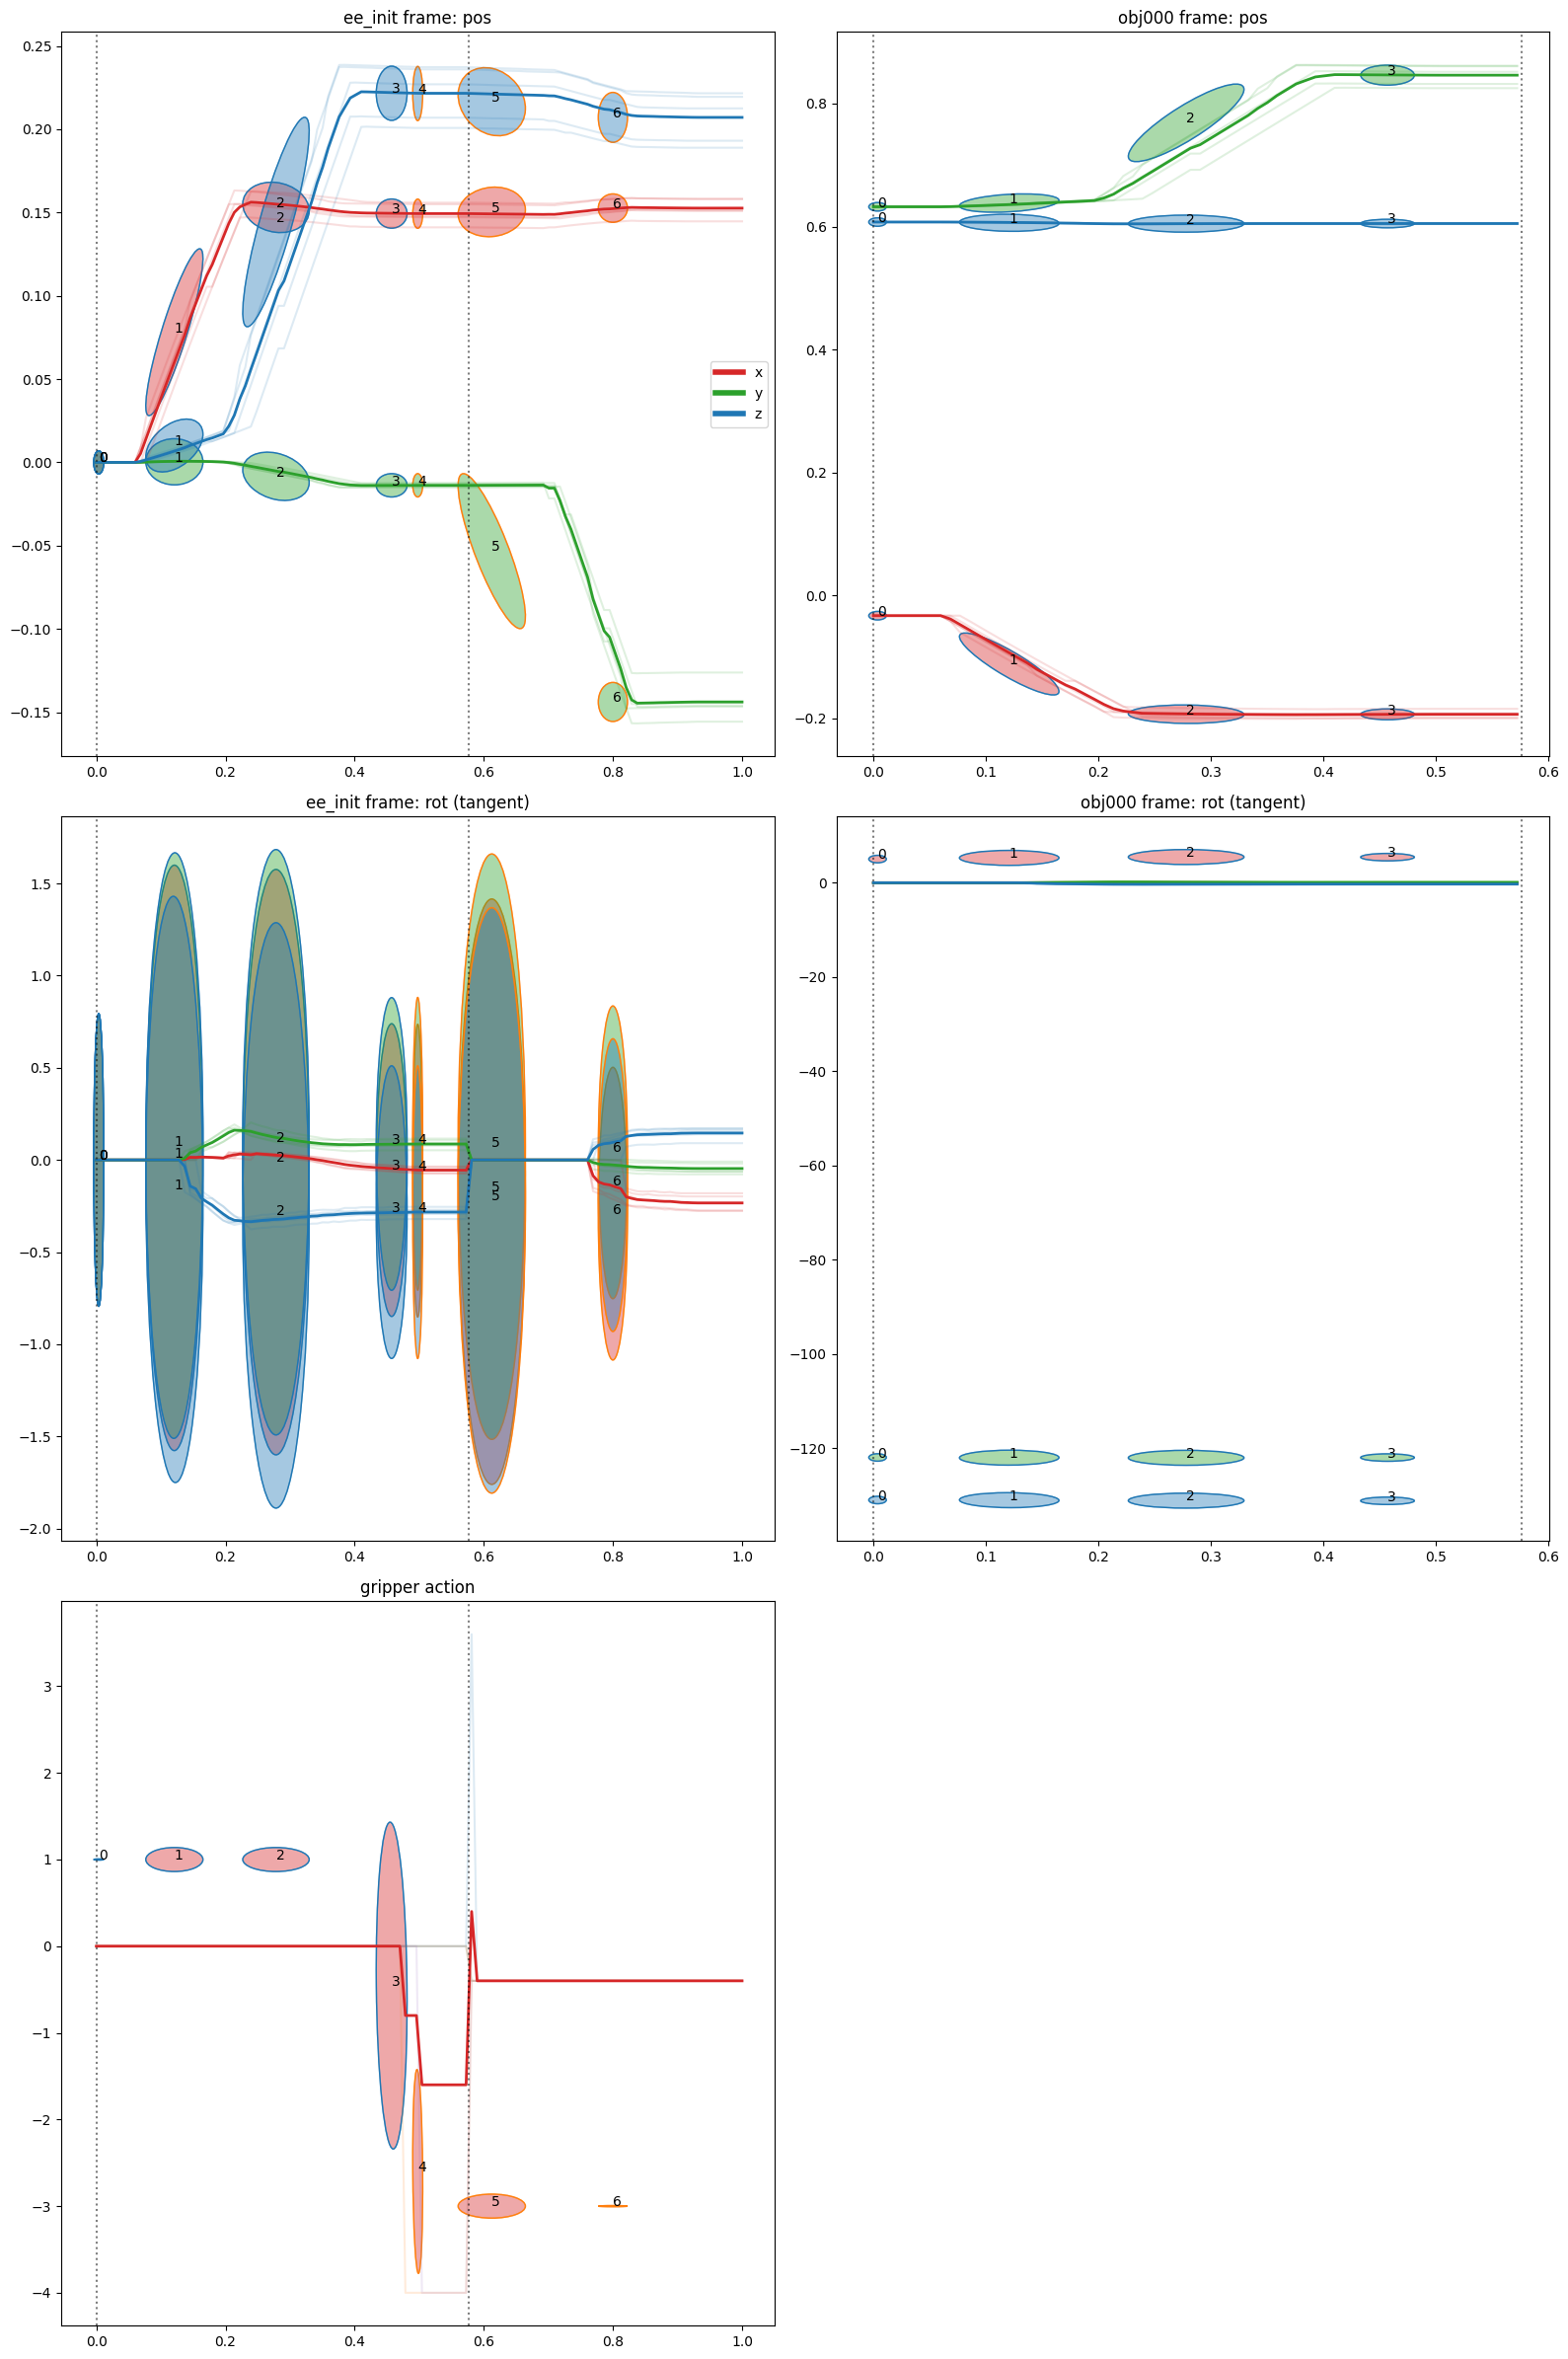

In [22]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

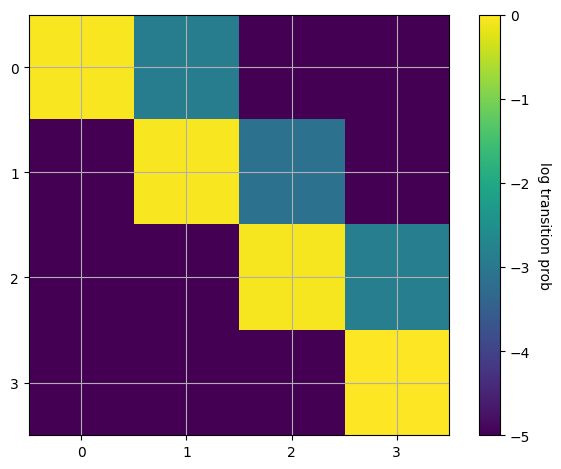

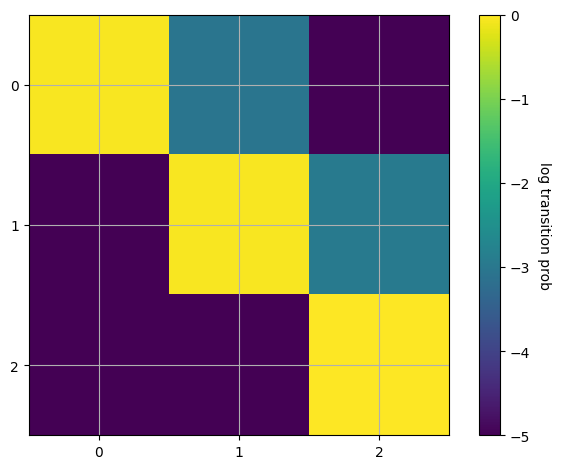

In [23]:
atpgmm.plot_hmm_transition_matrix()

In [24]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-06-16 22:05:22.659 | INFO     |  Saving model:


In [25]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-16 22:05:22.820 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-06-16 22:05:37.702 | INFO     |  Caculated segment transition probabilities: (array([[8.45e-08]]),)
2025-06-16 22:05:37.702 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-06-16 22:05:37.702 | INFO     |  Creating partial frame view of demos.
2025-06-16 22:05:37.748 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 22:05:37.874 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 22:05:37.926 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

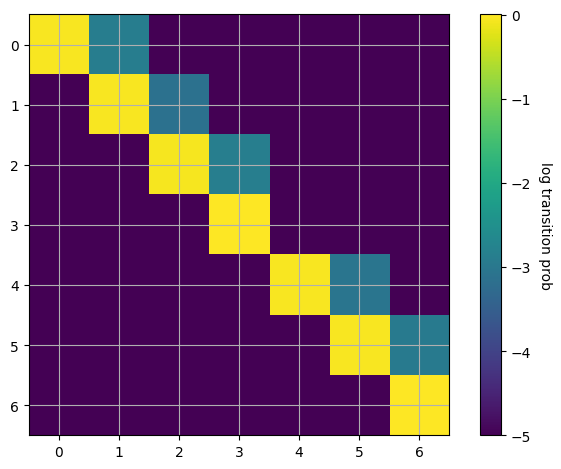

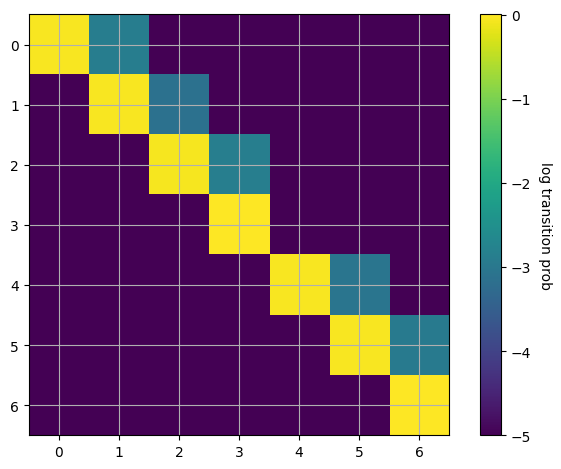

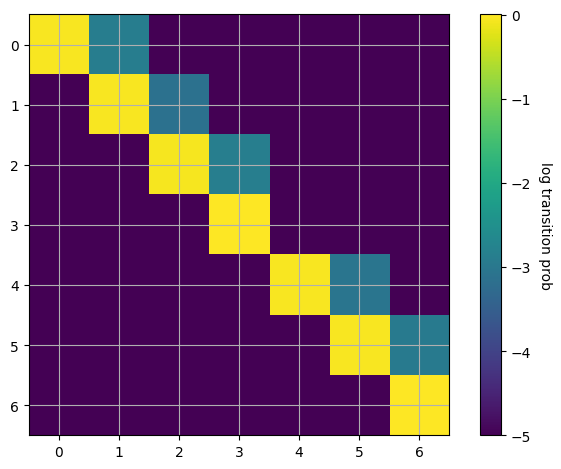

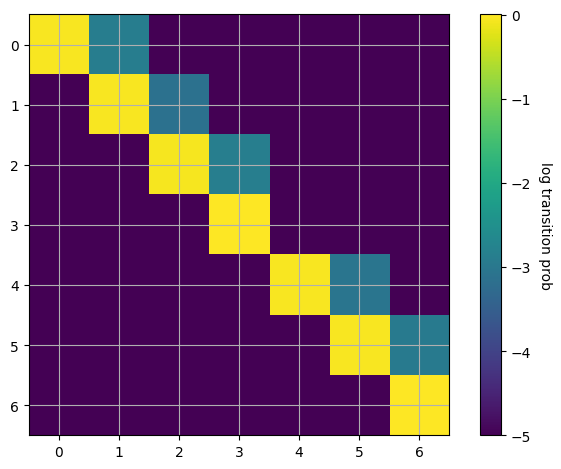

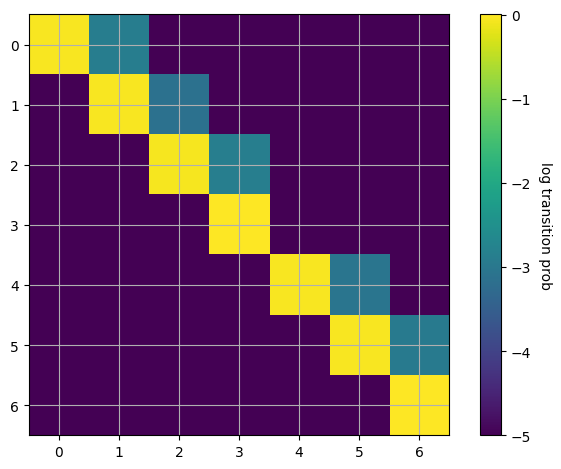

In [26]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-16 22:05:44.116 | INFO     |  Taking frame origins from demos.


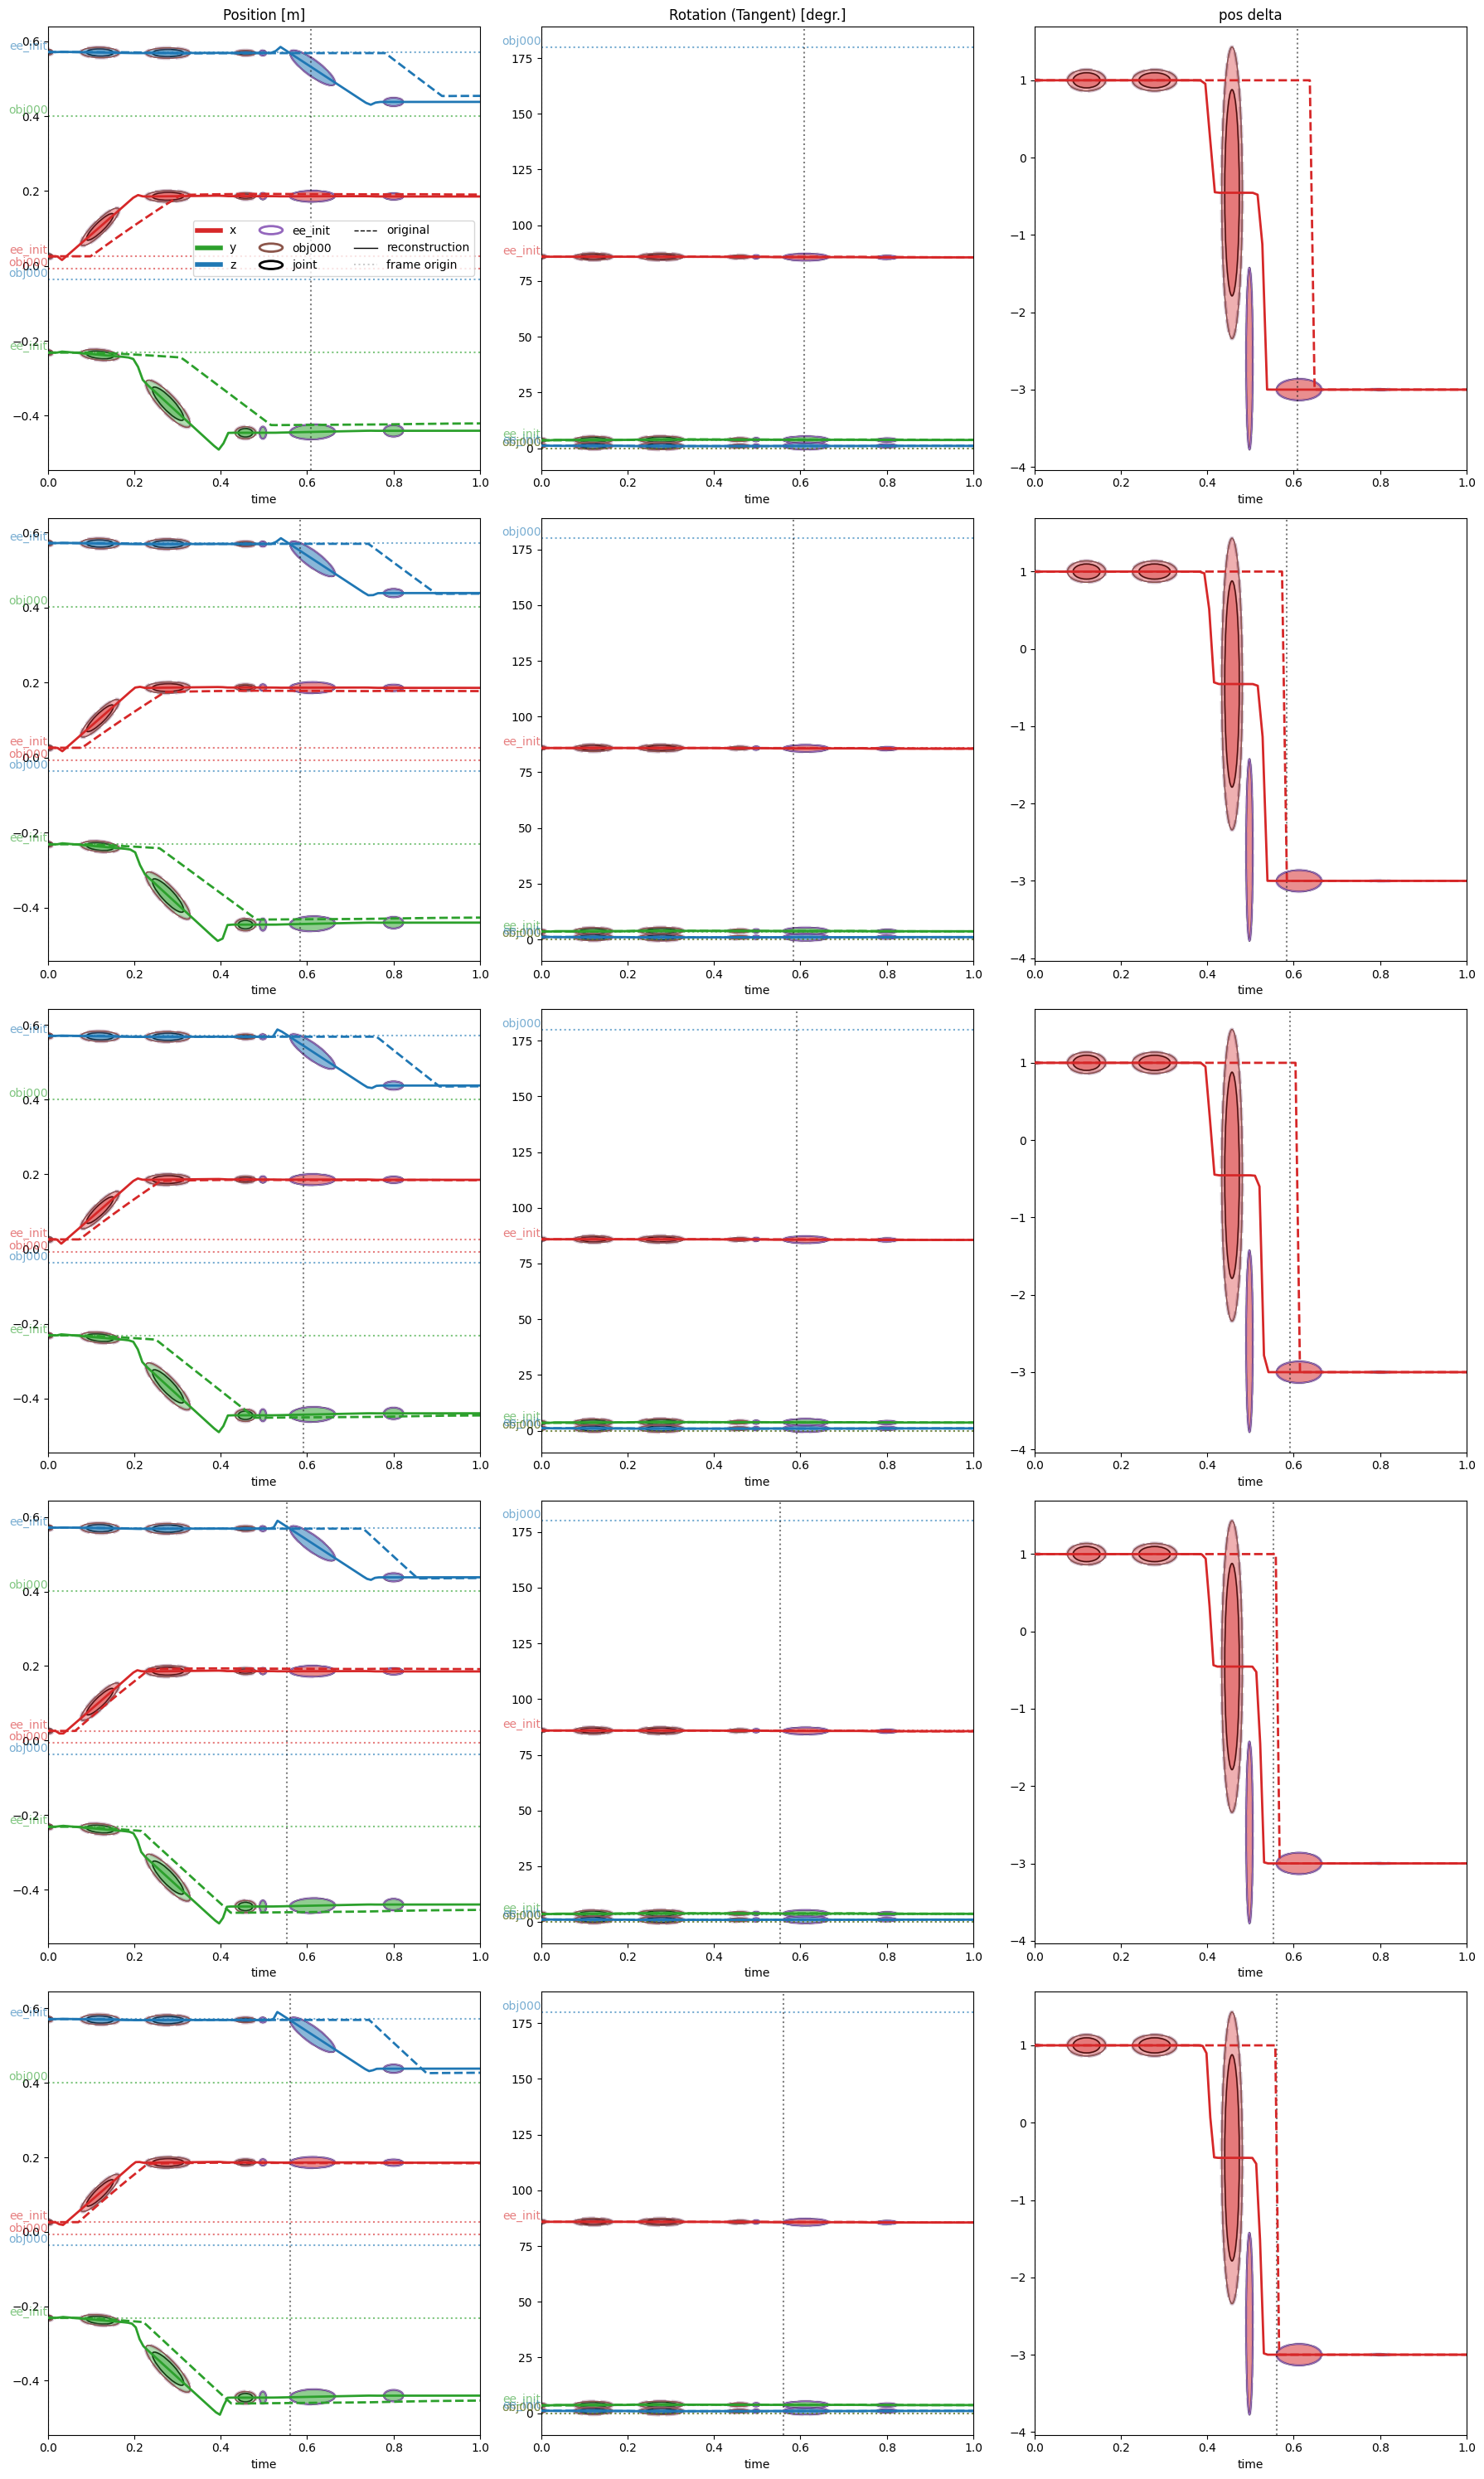

In [27]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [28]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-16 22:05:52.817 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'